# Self-synteny for WGD detection

If a whole-genome duplication (WGD) has happened in a lineage, we would expect to see at least some
corresponding chromosomes that carry multiple paralogous genes. Therefore, if we perform an
all-against-all search with protein sequences, set a relatively high e-value threshold (e.g.
$10^{-10}$ or $10^{-20}$) and exclude self-hits (i.e. search for paralogs), we should be able to see
a pattern. If WGD has taken place, we should be seeing many clustered off-diagonal hits, linking the
two paralogous chromosomes. However, if all that is seen is a random scatter of hits, then it is
likely that no WGD has occurred.

used this list to scan against the _P. litorale_ draft genome using `mmseqs`:

```bash
cd /lisc/scratch/zoology/pycnogonum/genome/draft/self_synteny
module load mmseqs2
M8FORMAT="query,target,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits,qlen"
proteome=/lisc/scratch/zoology/pycnogonum/genome/draft/transcripts.fa.transdecoder.pep
mmseqs easy-search $proteome $proteome self.m8 tmp --format-output $M8FORMAT --threads 16 --cov-mode 5 -c 0.8
```

For coverage mode, we compare the length of the shorter sequence to the longer one, and we ask that
at least 80% of the longer sequence is covered. This is because we are specifically looking for
paralogs, and we expect that duplicated genes should have roughly the same length.

We will need numpy and pandas for data wrangling, and matplotlib for plotting.

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

import seaborn as sns
from matplotlib import pyplot as plt

Some preparation first:

In [2]:
# we will need to read in the GFF file, because it holds the gene names and positions.
def read_gff(loc):
    gff = pd.read_csv(loc, sep="\t", header=None, skiprows=4)
    gff_columns = ['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes']
    gff.columns = gff_columns
    return gff

# the alignment file is similar to the BLAST tabular format, but we defined the columns in the
# `M8FORMAT` variable.
def read_aln(m8, id_sep=None):
    plit = pd.read_csv(m8, sep="\t", header=None)
    m8_columns = ['query', 'target', 'seq_id', 'ali_len', 'no_mism', 'no_go',
                'q_start', 'q_end', 't_start', 't_end', 'eval', 'bit', 'qlen']
    plit.columns = m8_columns
    # trim the query to just the ID
    if id_sep is not None:
        plit["query"] = plit["query"].str.split(id_sep).str[1]
    return plit

# in order to get the offsets right in the Oxford grid later, we need to know the length of all the
# chromosomes, hence we need to read the FASTA file.
def get_contig_lengths(fasta):
    lengths = {}
    with open(fasta, "r") as fh:
        for line in fh:
            if line.startswith(">"):
                contig = line.strip().split()[0].replace(">", "")
                lengths[contig] = 0
            else:
                lengths[contig] += len(line.strip())
    return lengths

# MMseqs2 takes the proteome as input; gene names will contain the transcript and protein IDs, so we
# need to remove those.
def extract_gene_name(x):
    if x.startswith("PB"):
        return ".".join(x.split(".")[0:2]).split(',')[0]
    elif x.startswith("g"):
        return x.split(".")[0]
    elif x.startswith("r2"):
        return x.split(".")[0]
    elif x.startswith("at"):
        return x.split(".")[0]
    else:
        return None

Read and parse the GFF file. Gene names should now be in a separate column.

In [3]:
gff_loc = "/Volumes/project/pycnogonum/paper/zenodo/results/merged_sorted_named_dedup_flagged.gff3"
fasta_loc = "/Volumes/project/pycnogonum/paper/zenodo/results/draft.fasta"

tmp = read_gff(gff_loc)
gff = tmp[tmp['type'] == 'gene'].copy()
gff['gene'] = gff['attributes'].str.split("ID=").str[1].str.split(";").str[0]
gff['gene'] = gff['gene'].str.split(',').str[0]
gff.set_index("gene", inplace=True)
del tmp

Parse the FASTA file to get the contig lengths:

In [4]:
contigs = get_contig_lengths(fasta_loc)

Read the alignment results, extract the gene names, and remove self-hits:

In [5]:
plit = read_aln('/Volumes/scratch/pycnogonum/genome/draft/self_synteny/self.m8')

plit['gene_from'] = plit['query'].apply(extract_gene_name)
plit['gene_to'] = plit['target'].apply(extract_gene_name)

remove = plit['gene_from'] == plit['gene_to']

The table is extremely redundant and very large, so we will filter it to just the top hits for each
pair of genes.

In [6]:
best = plit[~remove].groupby(['gene_from', 'gene_to'])['eval'].min().reset_index()

In [7]:
chromosomes = {x: contigs[x] for x in contigs.keys() if x.startswith("pseudochrom")}

offsets = {}
offsets["pseudochrom_1"] = 0

for i in np.arange(2, 58):
    offsets[f"pseudochrom_{i}"] = 0
    for j in np.arange(1, i):
        offsets[f"pseudochrom_{i}"] += contigs[f"pseudochrom_{j}"]

In [8]:
def calc_coordinates(row, gff, offsets):
    gene_from = row['gene_from']
    gene_to = row['gene_to']

    # get the chromosome for each gene
    chrom_from = gff['seqid'].loc[gene_from]
    chrom_to = gff['seqid'].loc[gene_to]

    # if either gene is on a scaffold, skip, we are not plotting those
    if chrom_from.startswith('scaffold') or chrom_to.startswith('scaffold'):
        return
    # if the genes are on the same chromosome, color them differently
    if chrom_from == chrom_to:
        col = 'red'
    else:
        col = 'darkgray'
    
    # get the middle of each gene
    start_from = gff['start'].loc[gene_from]
    end_from = gff['end'].loc[gene_from]
    loc_from = (start_from + end_from) / 2

    start_to = gff['start'].loc[gene_to]
    end_to = gff['end'].loc[gene_to]
    loc_to = (start_to + end_to) / 2

    # get the offset for each gene
    offset_from = offsets[chrom_from]
    offset_to = offsets[chrom_to]

    # plot the points
    y = loc_from + offset_from
    x = loc_to + offset_to

    # print(row['gene_from'], row['gene_to'], x, y)
    return x, y, col, chrom_from, chrom_to

In [9]:
tmp = best.apply(calc_coordinates, axis=1, gff=gff, offsets=offsets)
coordinates = pd.DataFrame(tmp.tolist(), columns=['x', 'y', 'col', 'chrom_from', 'chrom_to'])
best = best.join(coordinates)
best.dropna(inplace=True)
del tmp

However, if a gene has multiple paralogs on the same chromosome, we will count all of them,
potentially inflating the number of hits. Now that we know the chromosome location of each gene we
can filter out these cases. Of course, this could happen both ways (from-to, to-from), so we need to
filter both ways too.

In [10]:
best['min_eval'] = best.groupby(['gene_from', 'chrom_to'])['eval'].transform('min')
best = best[best['eval'] == best['min_eval']].reset_index().copy()
best.drop(columns=['min_eval'], inplace=True)
best['min_eval'] = best.groupby(['gene_to', 'chrom_from'])['eval'].transform('min')
best = best[best['eval'] == best['min_eval']].reset_index().copy()
best.drop(columns=['min_eval'], inplace=True)

The `best` table now holds, for each gene, the best hit per chromosome (if any). This means that
we can aggregate via the "gene_from" (actually even "gene_to", since we filtered that as well) and
get the total number of putative paralogs per chromosome. We are going to plot these best hits per
chromosome on a genome map to get a sense of whether there is widespread synteny, a sign of WGD.

For this, we will use an Oxford grid, where we will plot the chromosomes in sequential order on both
axes. Each `(gene_from, gene_to)` pair will then be placed in the corresponding cell of the grid,
based on the genomic coordinates of the genes (mid point between gene start and gene end).

For this to work we need to know the lengths of all the chromosomes, since when we plot a gene at
position `x` on chromosome `n` the actual coordinate will be $\sum{chrom[1:n-1]} + x$.

In [11]:
total_length = sum([x for x in chromosomes.values()])

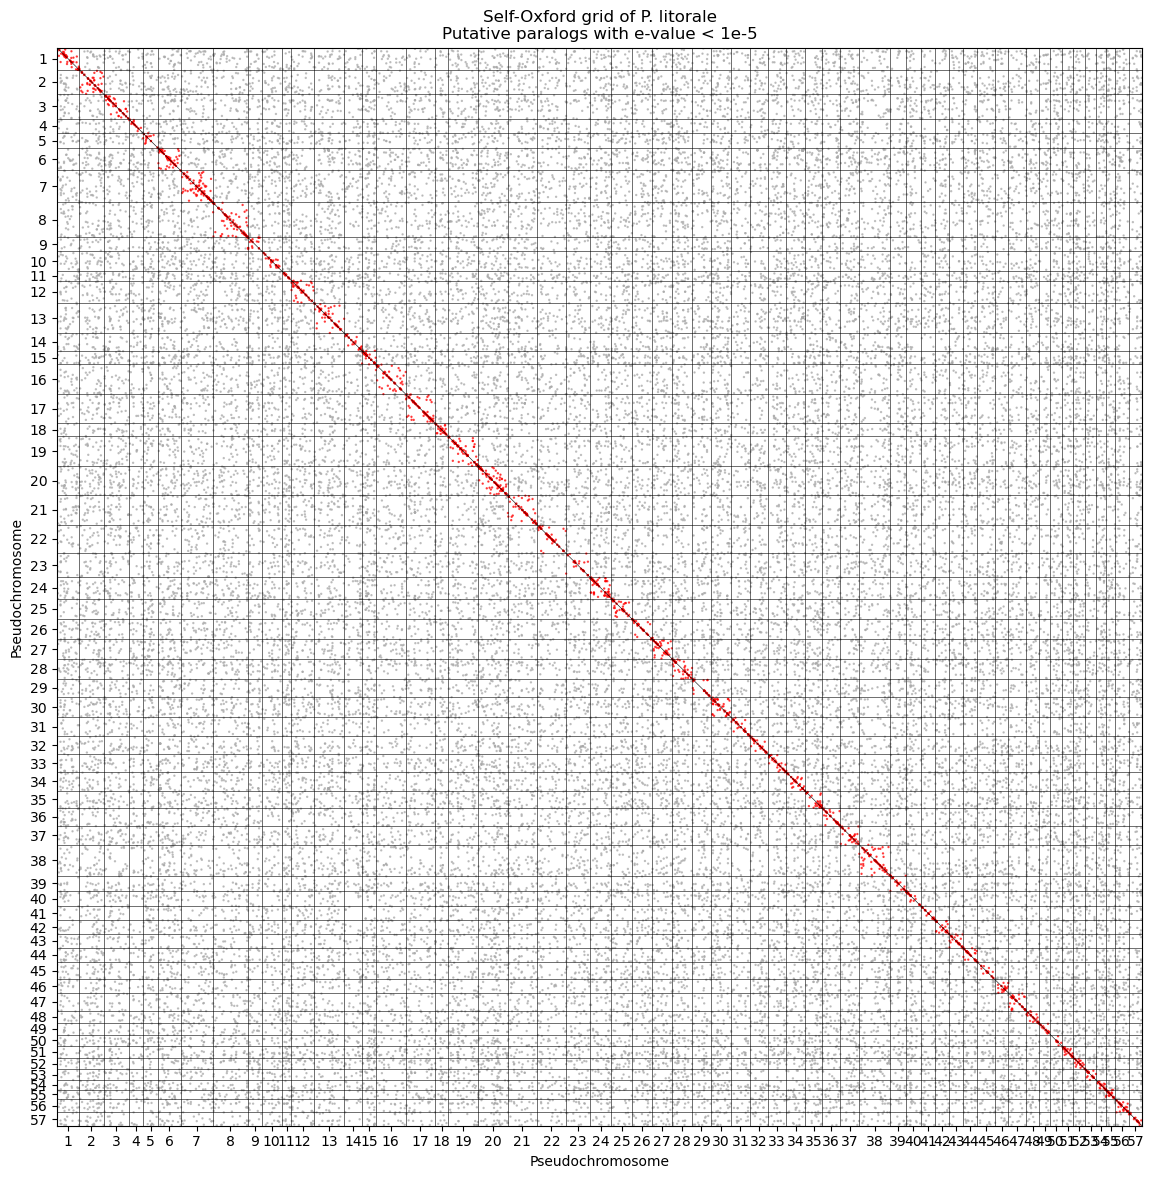

In [12]:
fig, ax = plt.subplots(figsize=(14, 14))

ax.set_xlim(0, total_length)
ax.set_ylim(0, total_length)
ax.set_xticks([offsets[x]+chromosomes[x]/2 for x in chromosomes.keys()])
ax.set_xticklabels([x.split('_')[1] for x in chromosomes.keys()])

ax.set_yticks([offsets[x]+chromosomes[x]/2 for x in chromosomes.keys()])
ax.set_yticklabels([x.split('_')[1] for x in chromosomes.keys()])

ax.yaxis.set_inverted(True)

ax.plot([0, total_length], [0, total_length], color='black', linestyle='-', linewidth=0.4)

for _, offset in offsets.items():
    ax.axvline(offset, color='black', linewidth=0.4)
    ax.axhline(offset, color='black', linewidth=0.4)

keep = best['eval'] < 1e-5
best[keep].plot.scatter(x='x', y='y', c='col', ax=ax, s=0.5, alpha=0.7);

ax.set_title('Self-Oxford grid of P. litorale\nPutative paralogs with e-value < 1e-5')
ax.set_xlabel('Pseudochromosome')
ax.set_ylabel('Pseudochromosome');

Are all of the "paralogs" the same genes, found over and over in other chromosomes? To look at that
we have to find all the unique genes that find at least one paralog. We can then count how many we
have per pseudochromosome, and translate that to percentages. Of course, the definition of a paralog
depends on the e-value threshold, so we should try a couple of different ones.

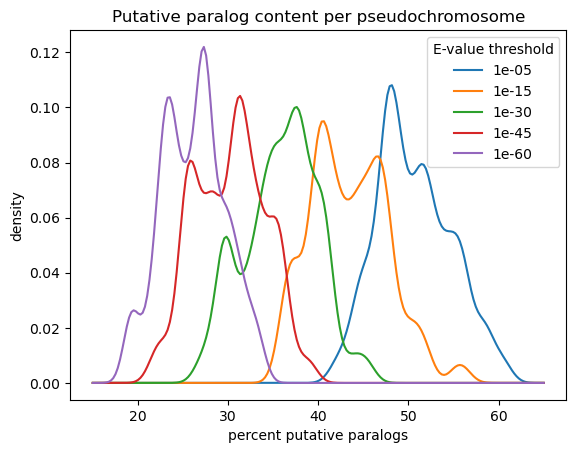

In [13]:
chrom_length = pd.DataFrame.from_dict(chromosomes, orient='index', columns=['length'])
total_genes = pd.DataFrame(gff['seqid'].value_counts())
fig, ax = plt.subplots()

for eval_threshold in [1e-5, 1e-15, 1e-30, 1e-45, 1e-60]:
    keep = best['eval'] < eval_threshold
    all_paralogs = pd.concat((best[keep]['gene_from'], best[keep]['gene_to']), axis=0).unique()

    total_paralogs = pd.DataFrame(gff.loc[all_paralogs]['seqid'].value_counts())
    total_paralogs = total_paralogs.join(chrom_length)
    total_paralogs.columns = ['#paralogs', 'chrom. length']
    total_paralogs = total_paralogs.join(total_genes)
    total_paralogs.columns = ['#paralogs', 'chrom. length', '#genes']

    total_paralogs['percent non-unique'] = total_paralogs['#paralogs'] / total_paralogs['#genes'] * 100
    density = gaussian_kde(total_paralogs['percent non-unique'])
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    xs = np.linspace(15, 65, 200)
    # fig, ax = plt.subplots()
    # ax.hist(total_paralogs['percent non-unique'], bins=20, alpha=0.3, label=f"{eval_threshold:.0e}", density=True)
    ax.plot(xs, density(xs), label=f"{eval_threshold:.0e}")

ax.set_xlabel('percent putative paralogs')
ax.set_ylabel('density')
ax.set_title('Putative paralog content per pseudochromosome')
ax.legend(title='E-value threshold');

The `best` table is much easier to interpret: each row shows the best hit for a gene on a
chromosome. We could aggregate the information in this table by asking how many hits go _from_ one
chromosome _to_ another one. Since we have filtered out redundancies, we could then translate this
number to a percentage of total genes in the _from_ chromosome. This would give us a measure of how
many genes on a chromosome are unique vs. shared with another chromosome. 

In [18]:
keep = best['eval'] < 1e-5
df = pd.pivot_table(best[keep], index='chrom_to', columns='chrom_from', aggfunc='size', fill_value=0)
df = df / gff['seqid'].value_counts()[df.index]

<Axes: xlabel='chrom_from', ylabel='chrom_to'>

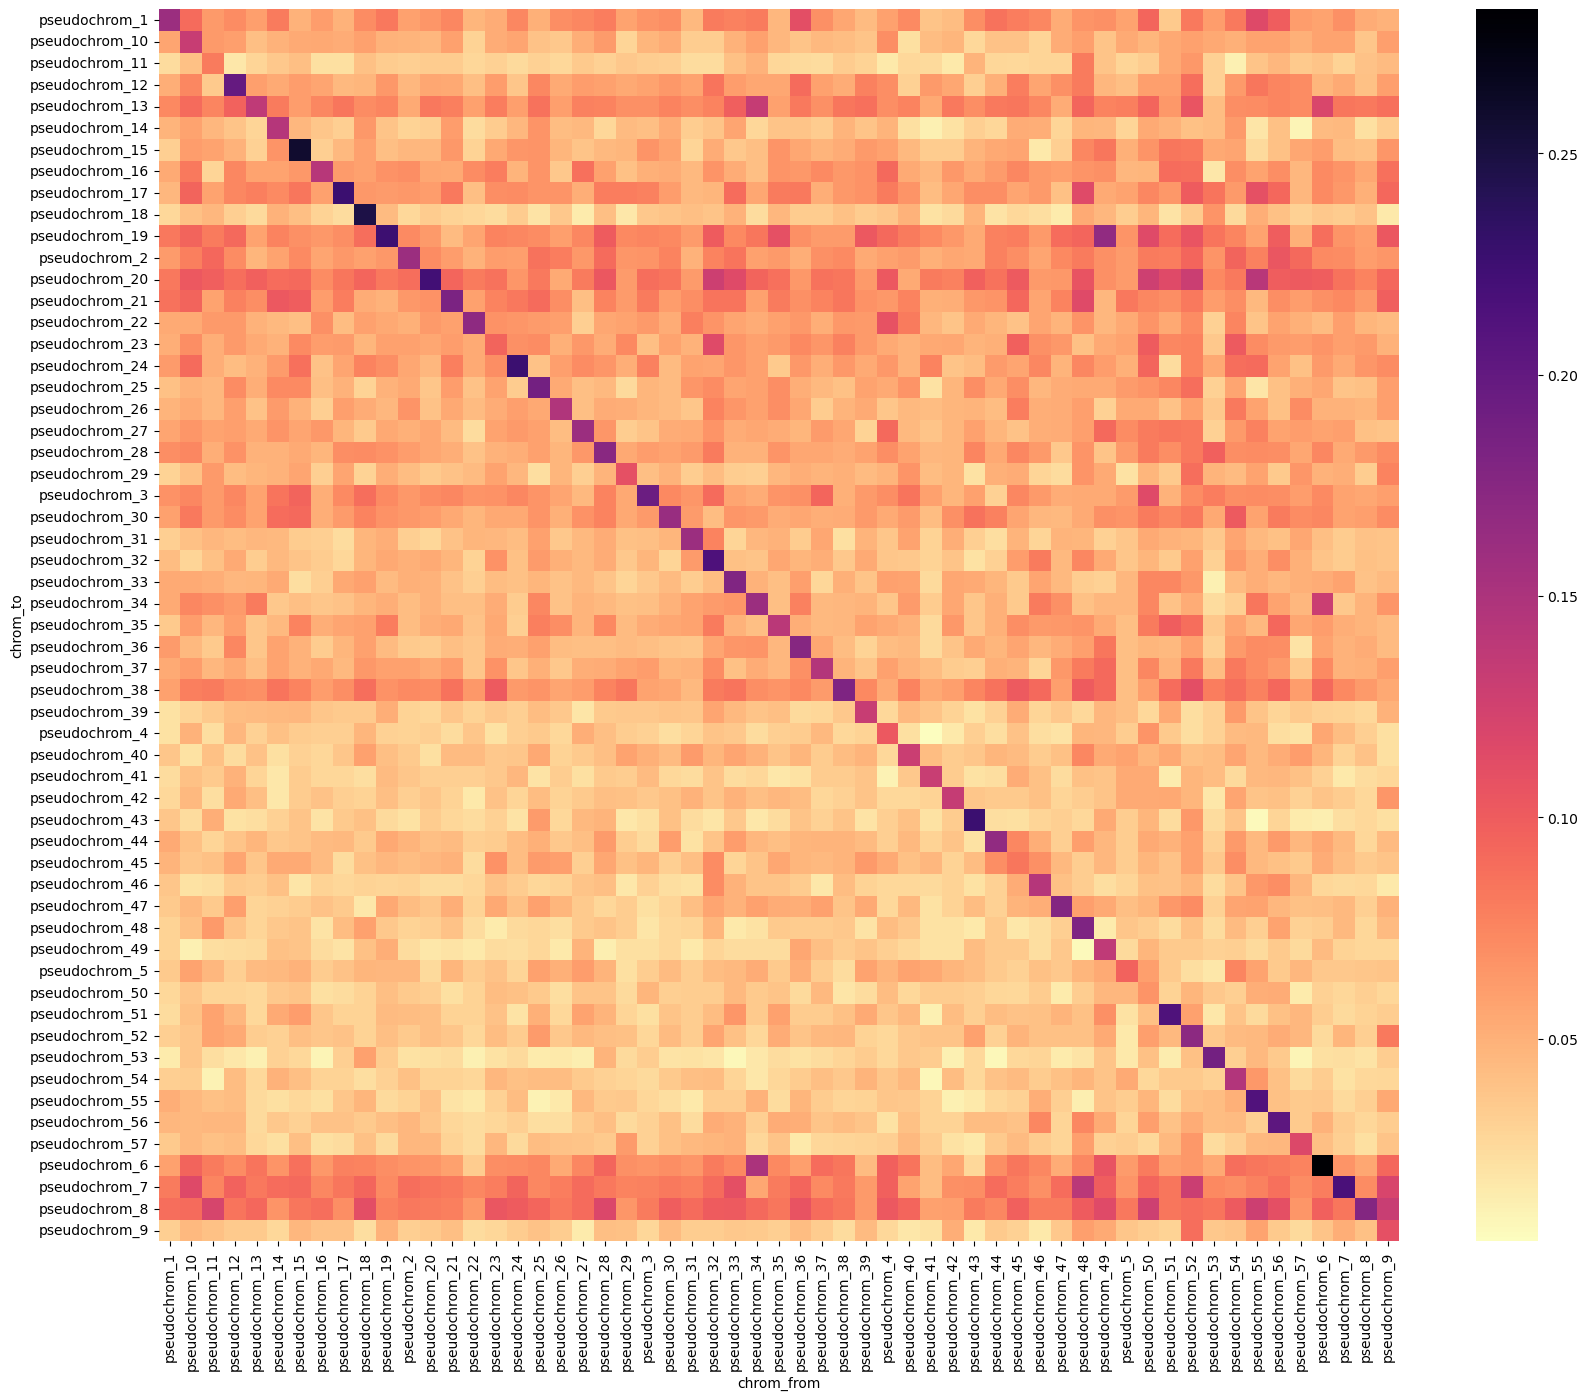

In [19]:
fig, ax = plt.subplots(figsize=(20, 16))
sns.heatmap(df, cmap='magma_r', ax=ax)

In [16]:
max_col = pd.DataFrame(df.apply(lambda x: x.idxmax(), axis=1))

In [17]:
np.fill_diagonal(df.values, 0)

df.min().min(), df.values[df.values>0].mean(), df.max().max()

(0.0, 0.015297372799691024, 0.08771929824561403)